In [14]:
%reset -f
import ROOT, math

%run -i ../eppi0_columns.py

fname = "../data/lvl2_eppi0.inb.qa.root"
fname="../data/lvl2_eppi0.outb.qa.root"

dsid = 'inb' if 'inb' in fname else 'outb'

df = ROOT.RDataFrame("h22",fname)

df = define_eppi0_columns_using_proton(df)

%run -i ../eppi0_binning_scheme_v2.py
shards,df  = define_eppi0_bins(df,dsid)

ecorrfile = '../code/utsav.inb.ele3phis.code' if 'inb' in fname else '../code/utsav.outb.ele3phis.code'
with open(ecorrfile) as ff:
    df = df.Define("fe",ff.read()+"return fe;")

inbstr = """
double dp = exp(-2.739 - 3.932*pp) + 0.002907;
if(thp>27) dp = exp(-1.2 - 4.228*pp) + 0.007502;
"""
outbstr = """
double dp = exp(-2.739 - 3.932*pp) + 0.002907;
if(thp>27) dp = exp(-1.871 - 3.063*pp) + 0.007517;
"""

corrstr = inbstr if 'inb' in fname else outbstr

df = df.Define("feloss",corrstr+"return (pp+dp)/pp;")

In [15]:
ROOT.gStyle.SetOptFit(1)
ROOT.gStyle.SetAxisColor(17)

dpps = [-0.15,-0.07,-0.04,0,0.04,0.07,0.15]
pplims = [0.3,0.6,0.7,0.85,1,1.05,1.2,1.3,1.4,1.5,2,2.5,3] if 'inb' in fname else [0.5,0.7,1,1.5,2,2.7,4]
#pplims = [1,1.2]

hss = {}
for dpp in dpps:
    bdf0 = df.Define("mm2z","double dpp = "+str(dpp)+""";
TLorentzVector beam(0,0,10.6041,10.6041), targ(0,0,0,0.938);
TLorentzVector ele, pro;

double fp = (feloss*pp + dpp)/pp;

ele.SetXYZM(fe*ex, fe*ey, fe*ez, 0);
pro.SetXYZM(fp*px, fp*py, fp*pz, 0.938);

double mm2z = (beam+targ-ele-pro).M2();
return mm2z;
""")
    
    for sec in range(1,7):
        bdf1 = bdf0.Filter(f"psec=={sec}")
        h2 = bdf1.Histo2D((str(("h2hmm2",sec,dpp)), str(("h2hmm2",sec,dpp)), 100,0.3,3, 100,-0.6,0.5), "pp", "mm2z")
        hss[(sec,dpp)]=h2
    
        for pp0,pp1 in zip(pplims[:-1], pplims[1:]):
            bdf2 = bdf1.Filter(f"pp>{pp0} && pp<{pp1}")
            h1 = bdf2.Histo1D((str(('mm2',dpp,sec,pp0,pp1)), str(('mm2',dpp,sec,pp0,pp1)), 200,-0.6,0.5), "mm2z")
            ppm = bdf2.Mean("pp")
            
            hss[(sec,dpp,ppm)] = h1

In [16]:
def fitslice(h1):
    f1 = ROOT.TF1("f1"+h1.GetName(), "gaus(0)+pol1(3)", -0.53,0.34)
    f1.SetLineWidth(1)
    f1.SetParameters(1,0,0.1,1,1)
    f1.SetParLimits(1,-0.4,0.31)
    f1.SetParLimits(2,0.01,0.21)
    h1.Fit(f1,"QR")
    mu,sig = f1.GetParameter(1), f1.GetParameter(2)
    f1.SetRange(mu-3*sig, mu+3*sig)
    h1.Fit(f1,"QR")
    setattr(h1,'f1',f1)

from collections import defaultdict
grs = defaultdict(lambda: ROOT.TGraphErrors())
grmm2s = defaultdict(lambda: ROOT.TGraphErrors())

for key in [kk for kk in hss if len(kk)>2]:
    h1 = hss[key]
    sec,dpp,ppm = key
    fitslice(h1)
    kk = (sec,round(ppm.GetValue(),3))
    gr = grs[kk]
    gr.SetTitle(str(kk))
    gr.SetPoint(gr.GetN(), dpp, h1.f1.GetParameter(1))
    gr.SetPointError(gr.GetN()-1, 0, h1.f1.GetParError(1))
    
    if(dpp==0):
        grmm2 = grmm2s[sec]
        grmm2.SetPoint(grmm2.GetN(), ppm.GetValue(), h1.f1.GetParameter(1))
        grmm2.SetPointError(grmm2.GetN()-1, 0, h1.f1.GetParError(1))

Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


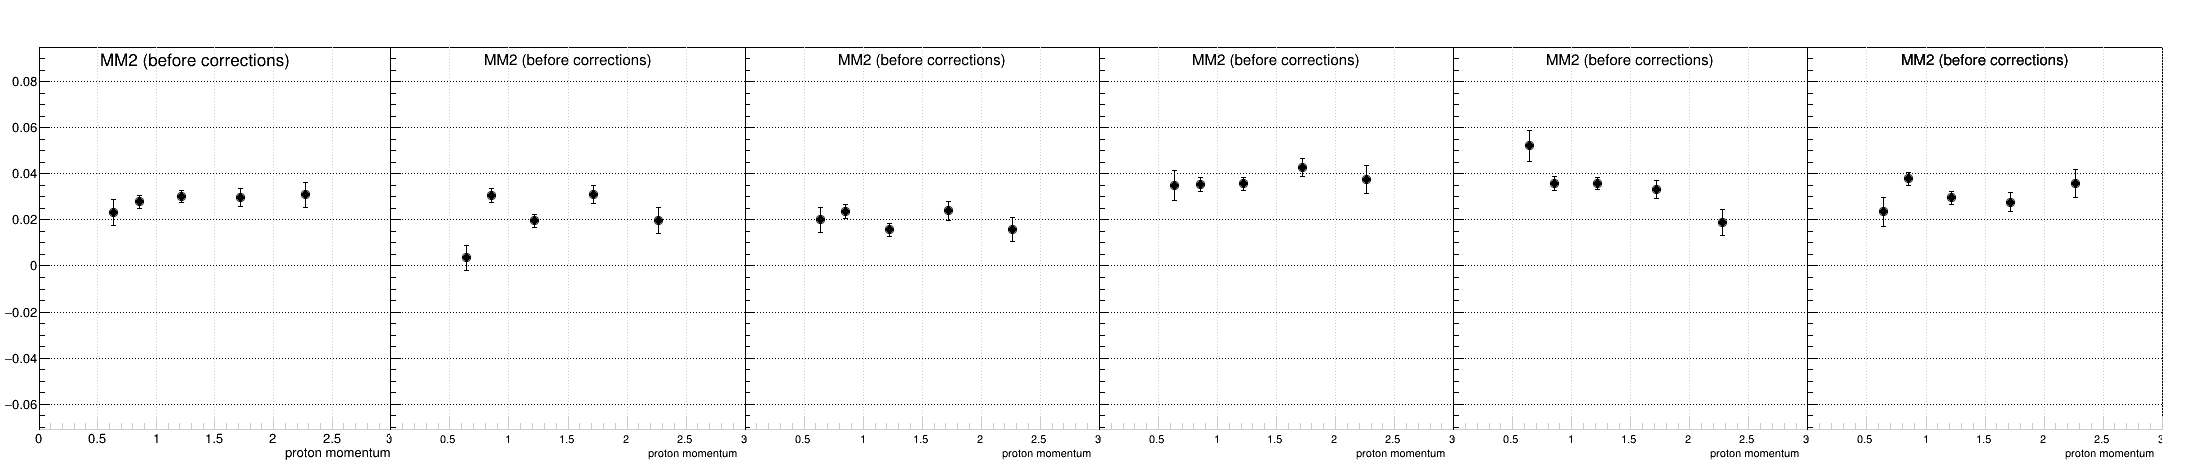

In [17]:
c1 = ROOT.TCanvas("c1","canvas",2200,500)
c1.Draw()
c1.Divide(6,1,0,0)

for sec in range(1,7):
    h1 = c1.cd(sec).DrawFrame(0,-0.071,3,0.095)
    c1.cd(sec).SetGrid()
    gr=grmm2s[sec]
    gr.Draw("P0")
    gr.SetMarkerStyle(20)
    h1.SetTitle("MM2 (before corrections);proton momentum;MM2")


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


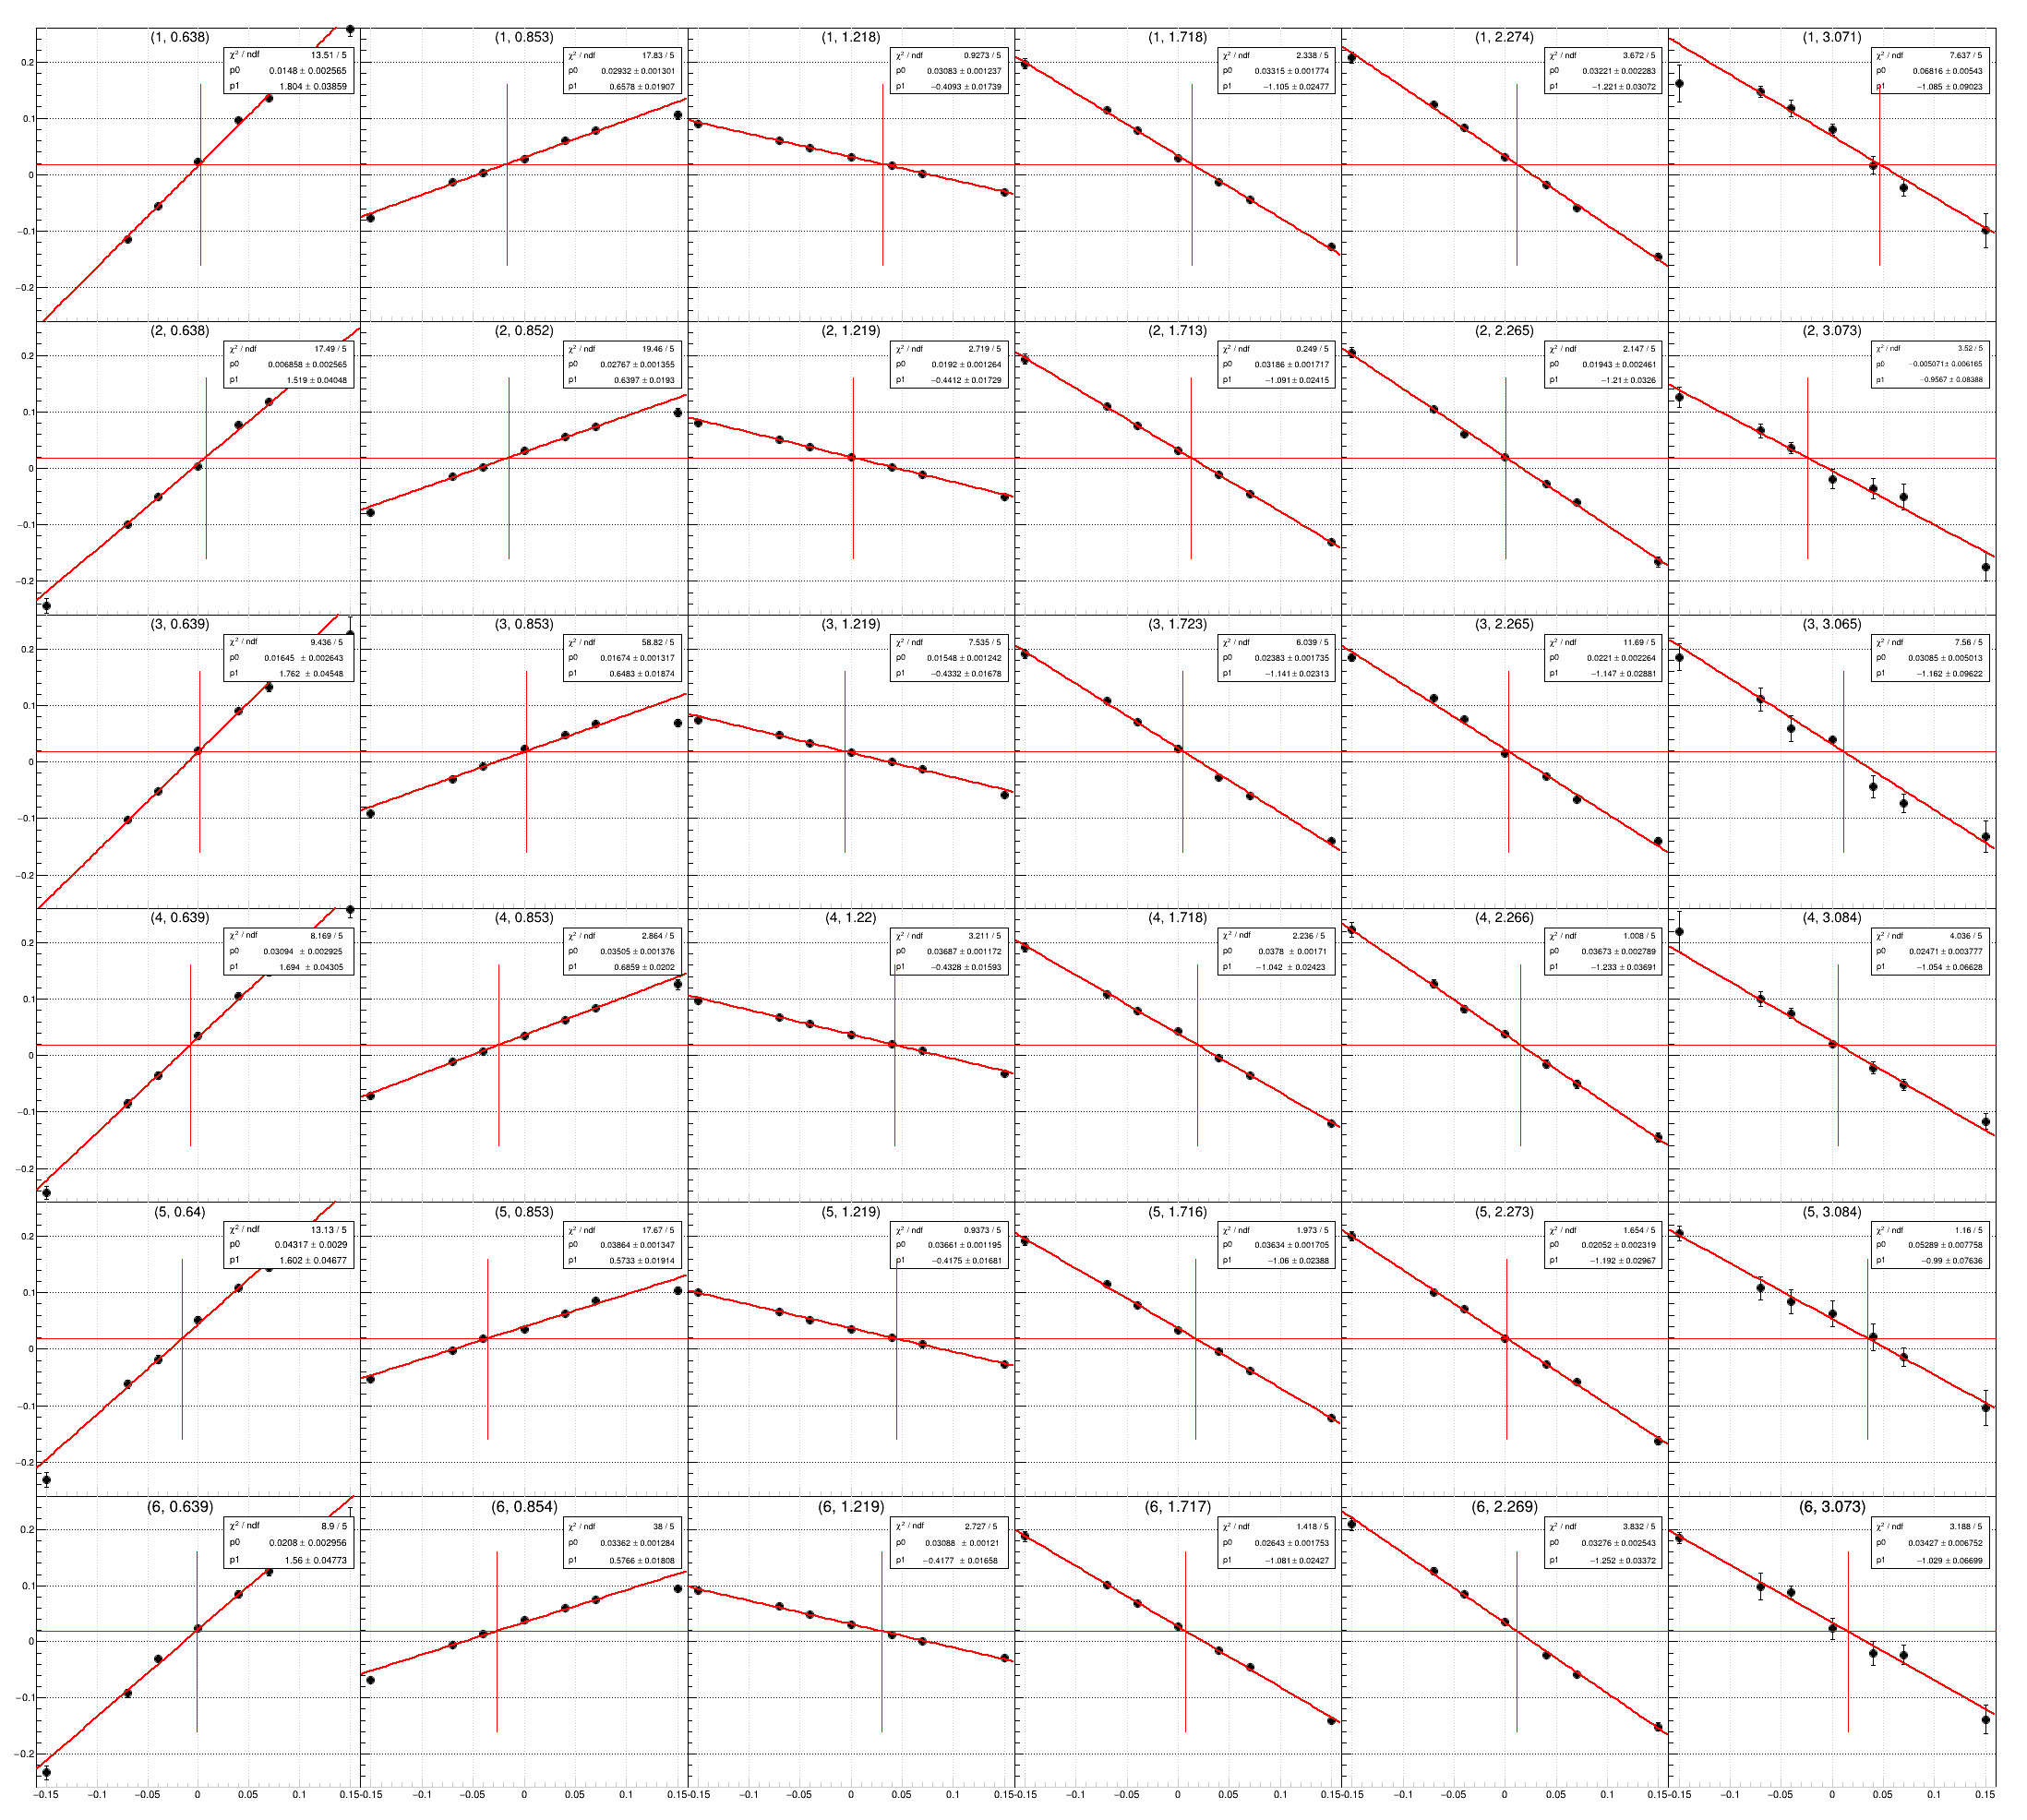

In [18]:
c1 = ROOT.TCanvas("c1","canvas",2200,2000)
c1.Draw()
c1.Divide(len(pplims)-1,6,0,0)

grdpps=[ROOT.TGraphErrors() for isec in range(6)]

ll = ROOT.TLine()
ll.SetLineColor(2)
ipad = 0
for kk in sorted(grs):
    ipad+=1
    h1 = c1.cd(ipad).DrawFrame(-0.16,-0.26,0.16,0.26)
    c1.cd(ipad).SetGrid()
    
    gr=grs[kk]
    h1.SetTitle(gr.GetTitle())
    gr.Draw("P")
    gr.SetMarkerStyle(20)
    f1 = ROOT.TF1("f1"+str(gr),"pol1",-1,1)
    gr.Fit(f1,'q')

    sec,ppm = kk
    gr1=grdpps[sec-1]
    p0,p1 = f1.GetParameter(0), f1.GetParameter(1)
    dp0,dp1 = f1.GetParError(0), f1.GetParError(1)
    dpp = (0.018225-p0)/p1
    ddpp = math.sqrt((dp0/p1)**2 + (dp1*(0.018225-p0)/p1**2)**2)
    gr1.SetPoint(gr1.GetN(), ppm, dpp)
    gr1.SetPointError(gr1.GetN()-1, 0, ddpp)
    
    ll.DrawLine(dpp, -0.16, dpp, 0.16)
    ll.DrawLine(-0.16,0.018225,0.16,0.018225)

dpp=exp(-7.044535961907246+1.2682246940432151*pp);
dpp=exp(-5.954735020934688+0.16030415164163267*pp);
dpp=exp(-7.6079381655152565+0.9913799045821844*pp);
dpp=exp(-6.177214600373113+0.7324003320757646*pp);
dpp=exp(0.5004781712348354+-34.62687427259052*pp);
dpp=exp(-14.944696160642582+-2.229221377459659*pp);


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


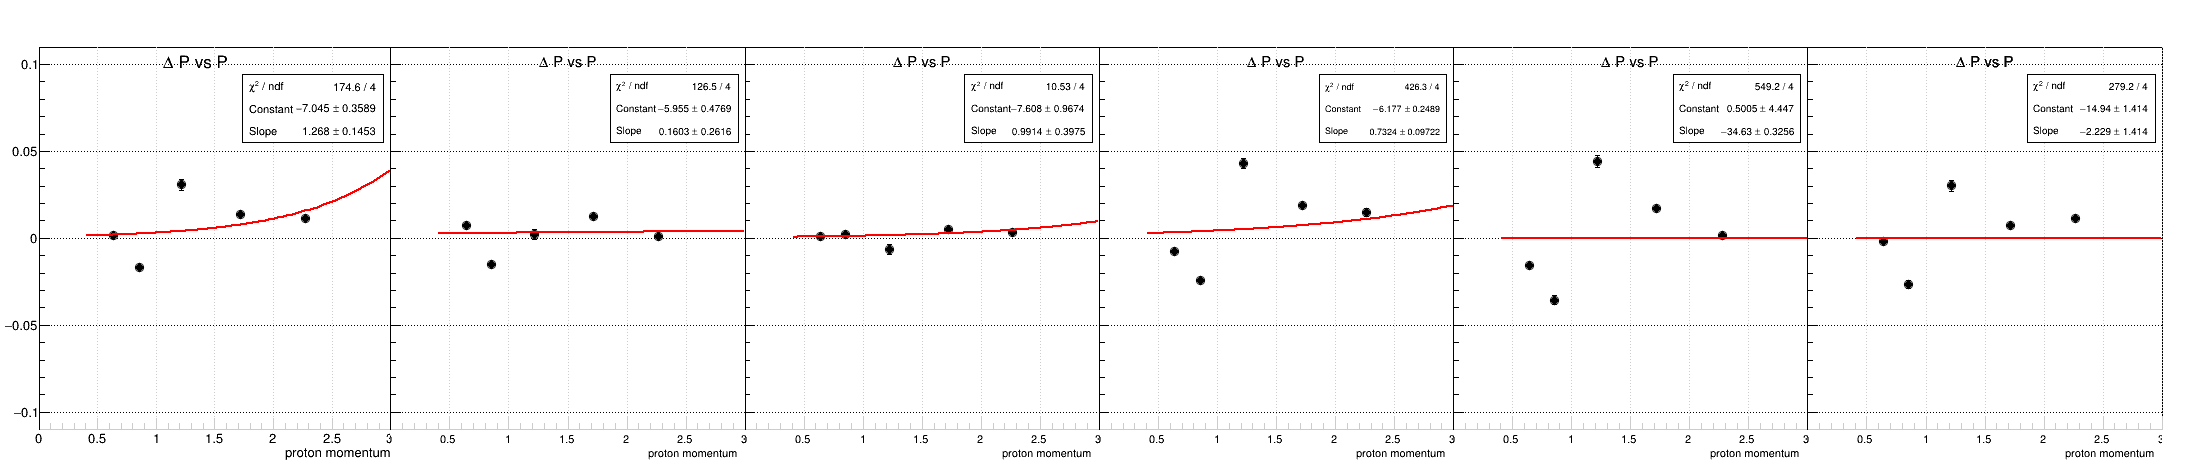

In [19]:
c1 = ROOT.TCanvas("c1","canvas",2200,500)
c1.Draw()
c1.Divide(6,1,0,0)

for sec in range(1,7):
    c1.cd(sec).DrawFrame(0,-0.11,3,0.11).SetTitle("#Delta P vs P;proton momentum;#Delta P")
    c1.cd(sec).SetGrid()
    gr=grdpps[sec-1]
    gr.Draw("P0")
    gr.SetMarkerStyle(20)
    
    f1 = ROOT.TF1("f1."+str(id(gr)),"pol1",0,3)
    p0,p1 = f1.GetParameter(0),f1.GetParameter(1)
    #print(f"dpp1={p0}+{p1}*pp;")

    f1 = ROOT.TF1("f1."+str(id(gr)),"expo(0)+pol0(2)",0,3)
    p0,p1,p2 = f1.GetParameter(0),f1.GetParameter(1),f1.GetParameter(2)
    #print(f"dpp1=exp({p0}+{p1}*pp)+{p2};")

    f1 = ROOT.TF1("f1."+str(id(gr)),"expo",0,3)
    p0,p1 = f1.GetParameter(0),f1.GetParameter(1)
    #print(f"dpp1=exp({p0}+{p1}*pp);")

    gr.Fit(f1,"Q")
    
    p0,p1 = f1.GetParameter(0),f1.GetParameter(1)
    print(f"dpp=exp({p0}+{p1}*pp);")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


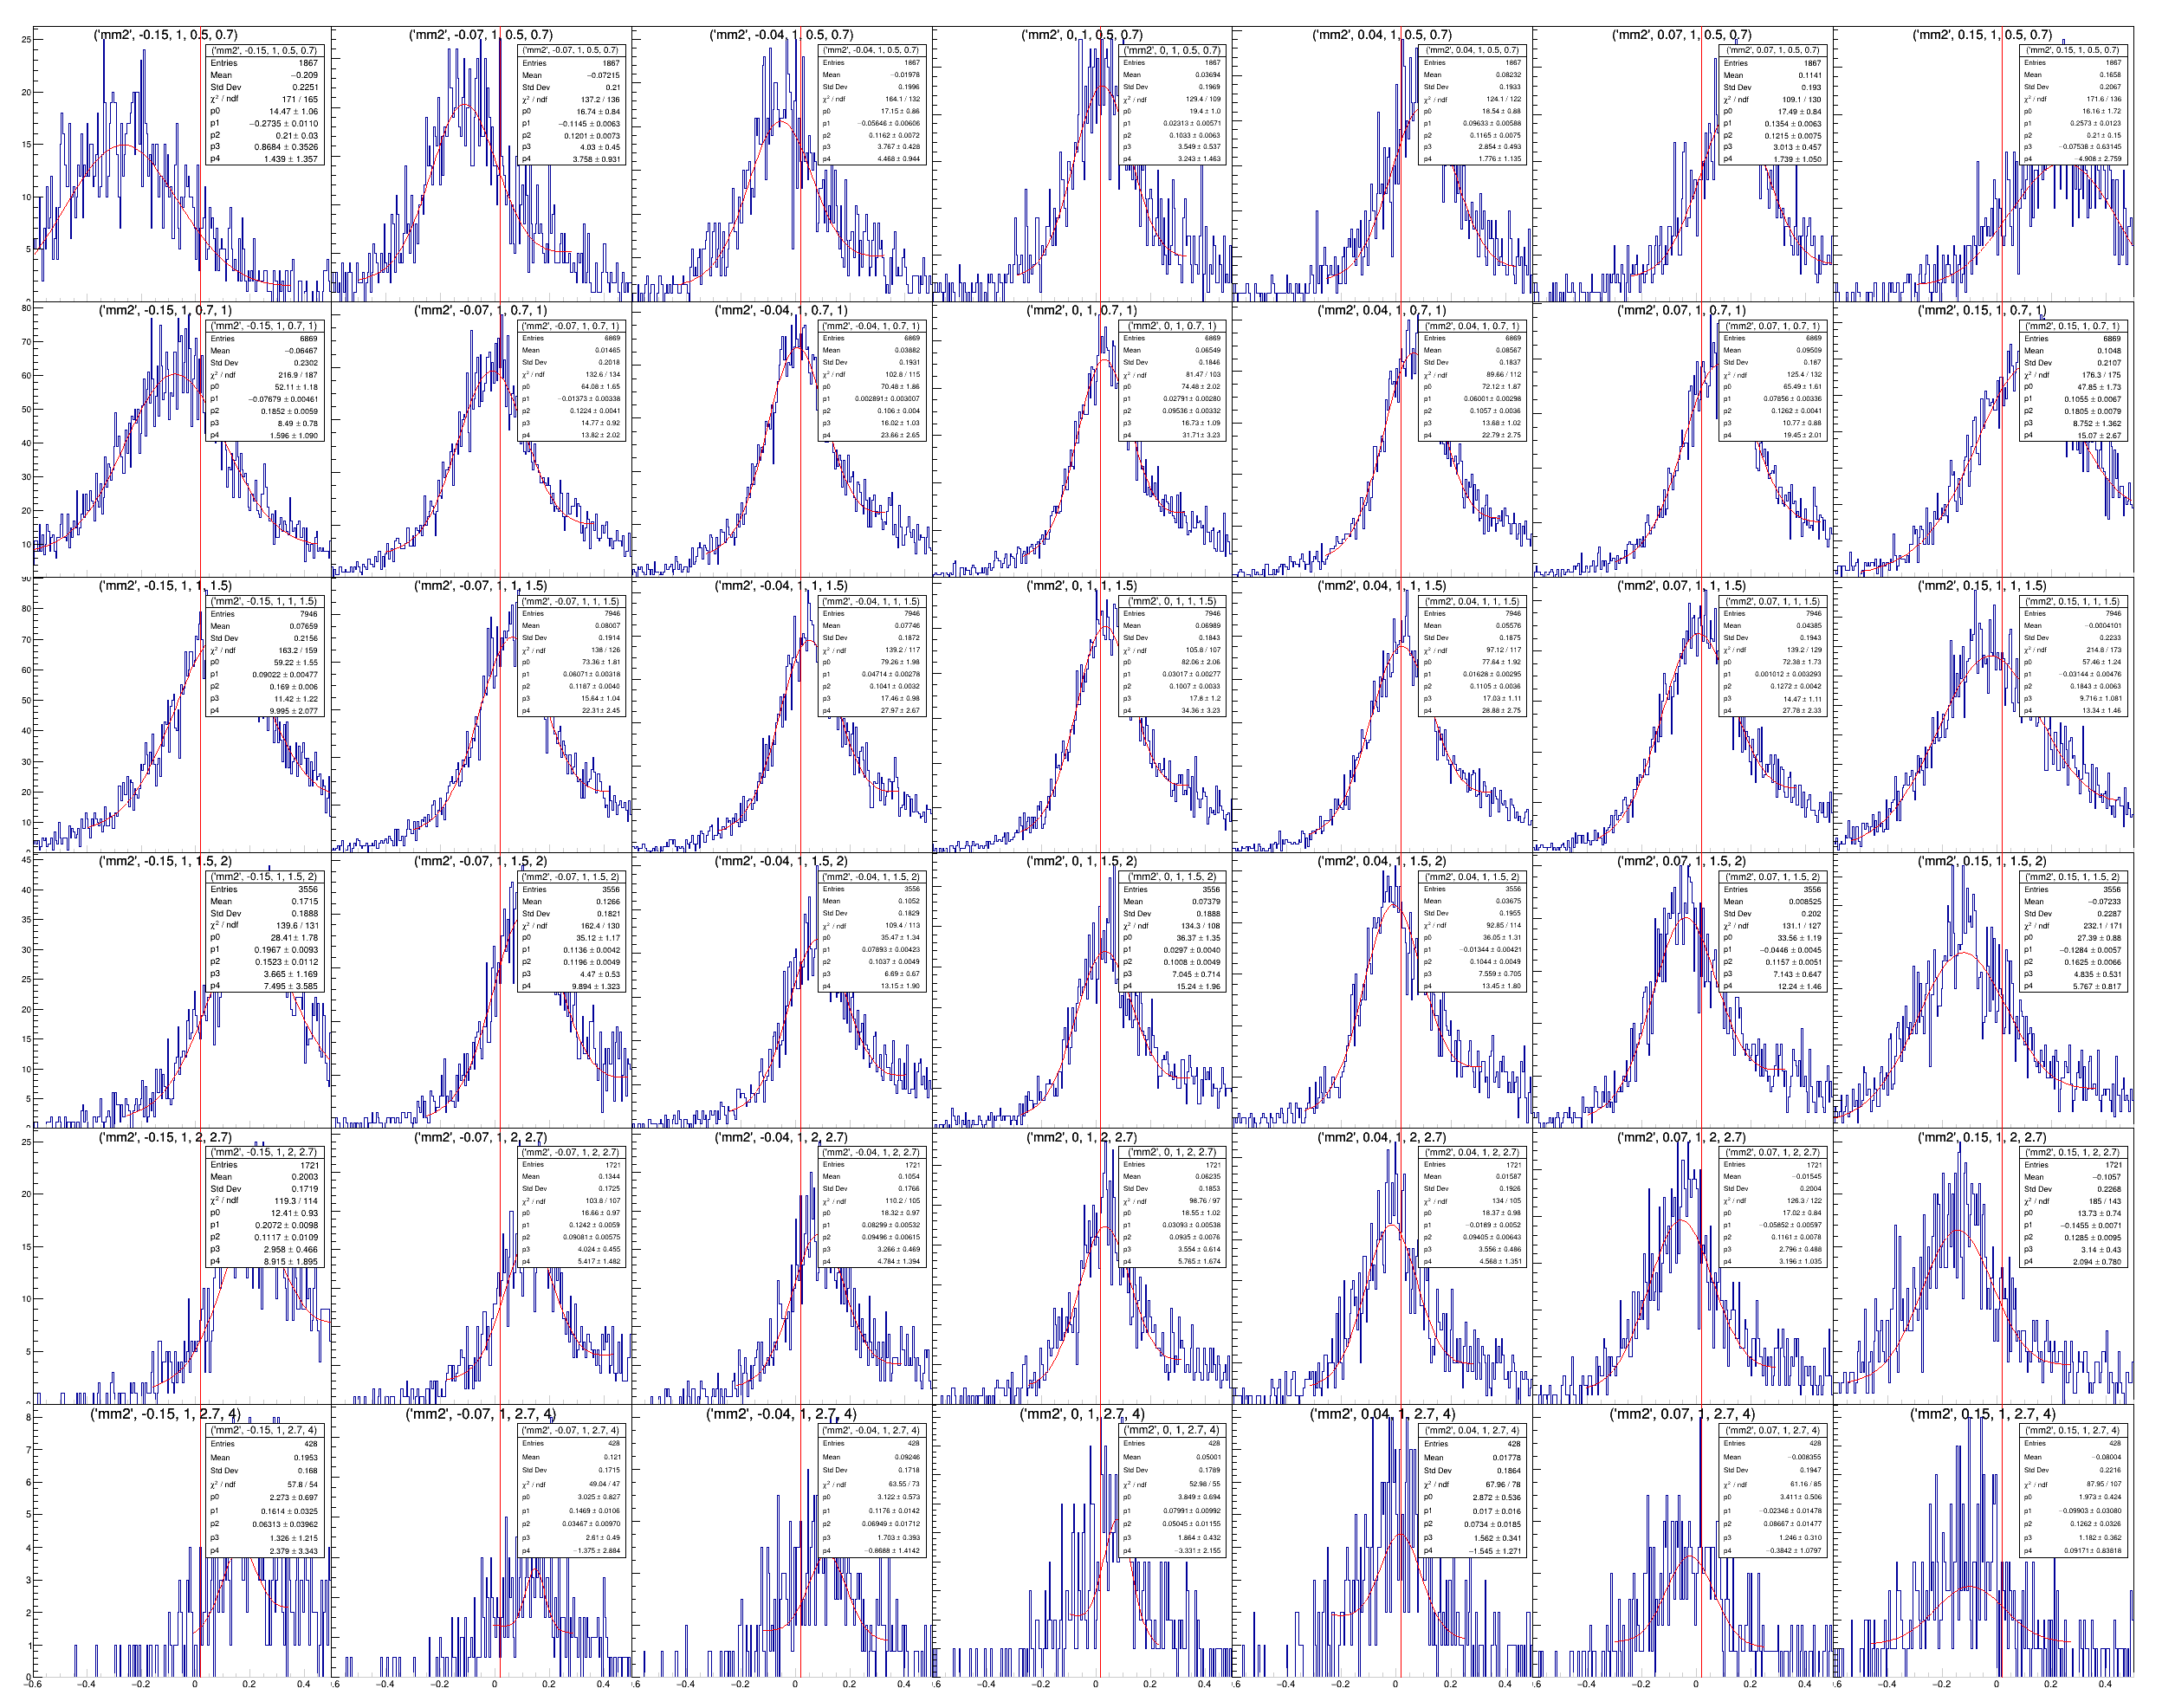

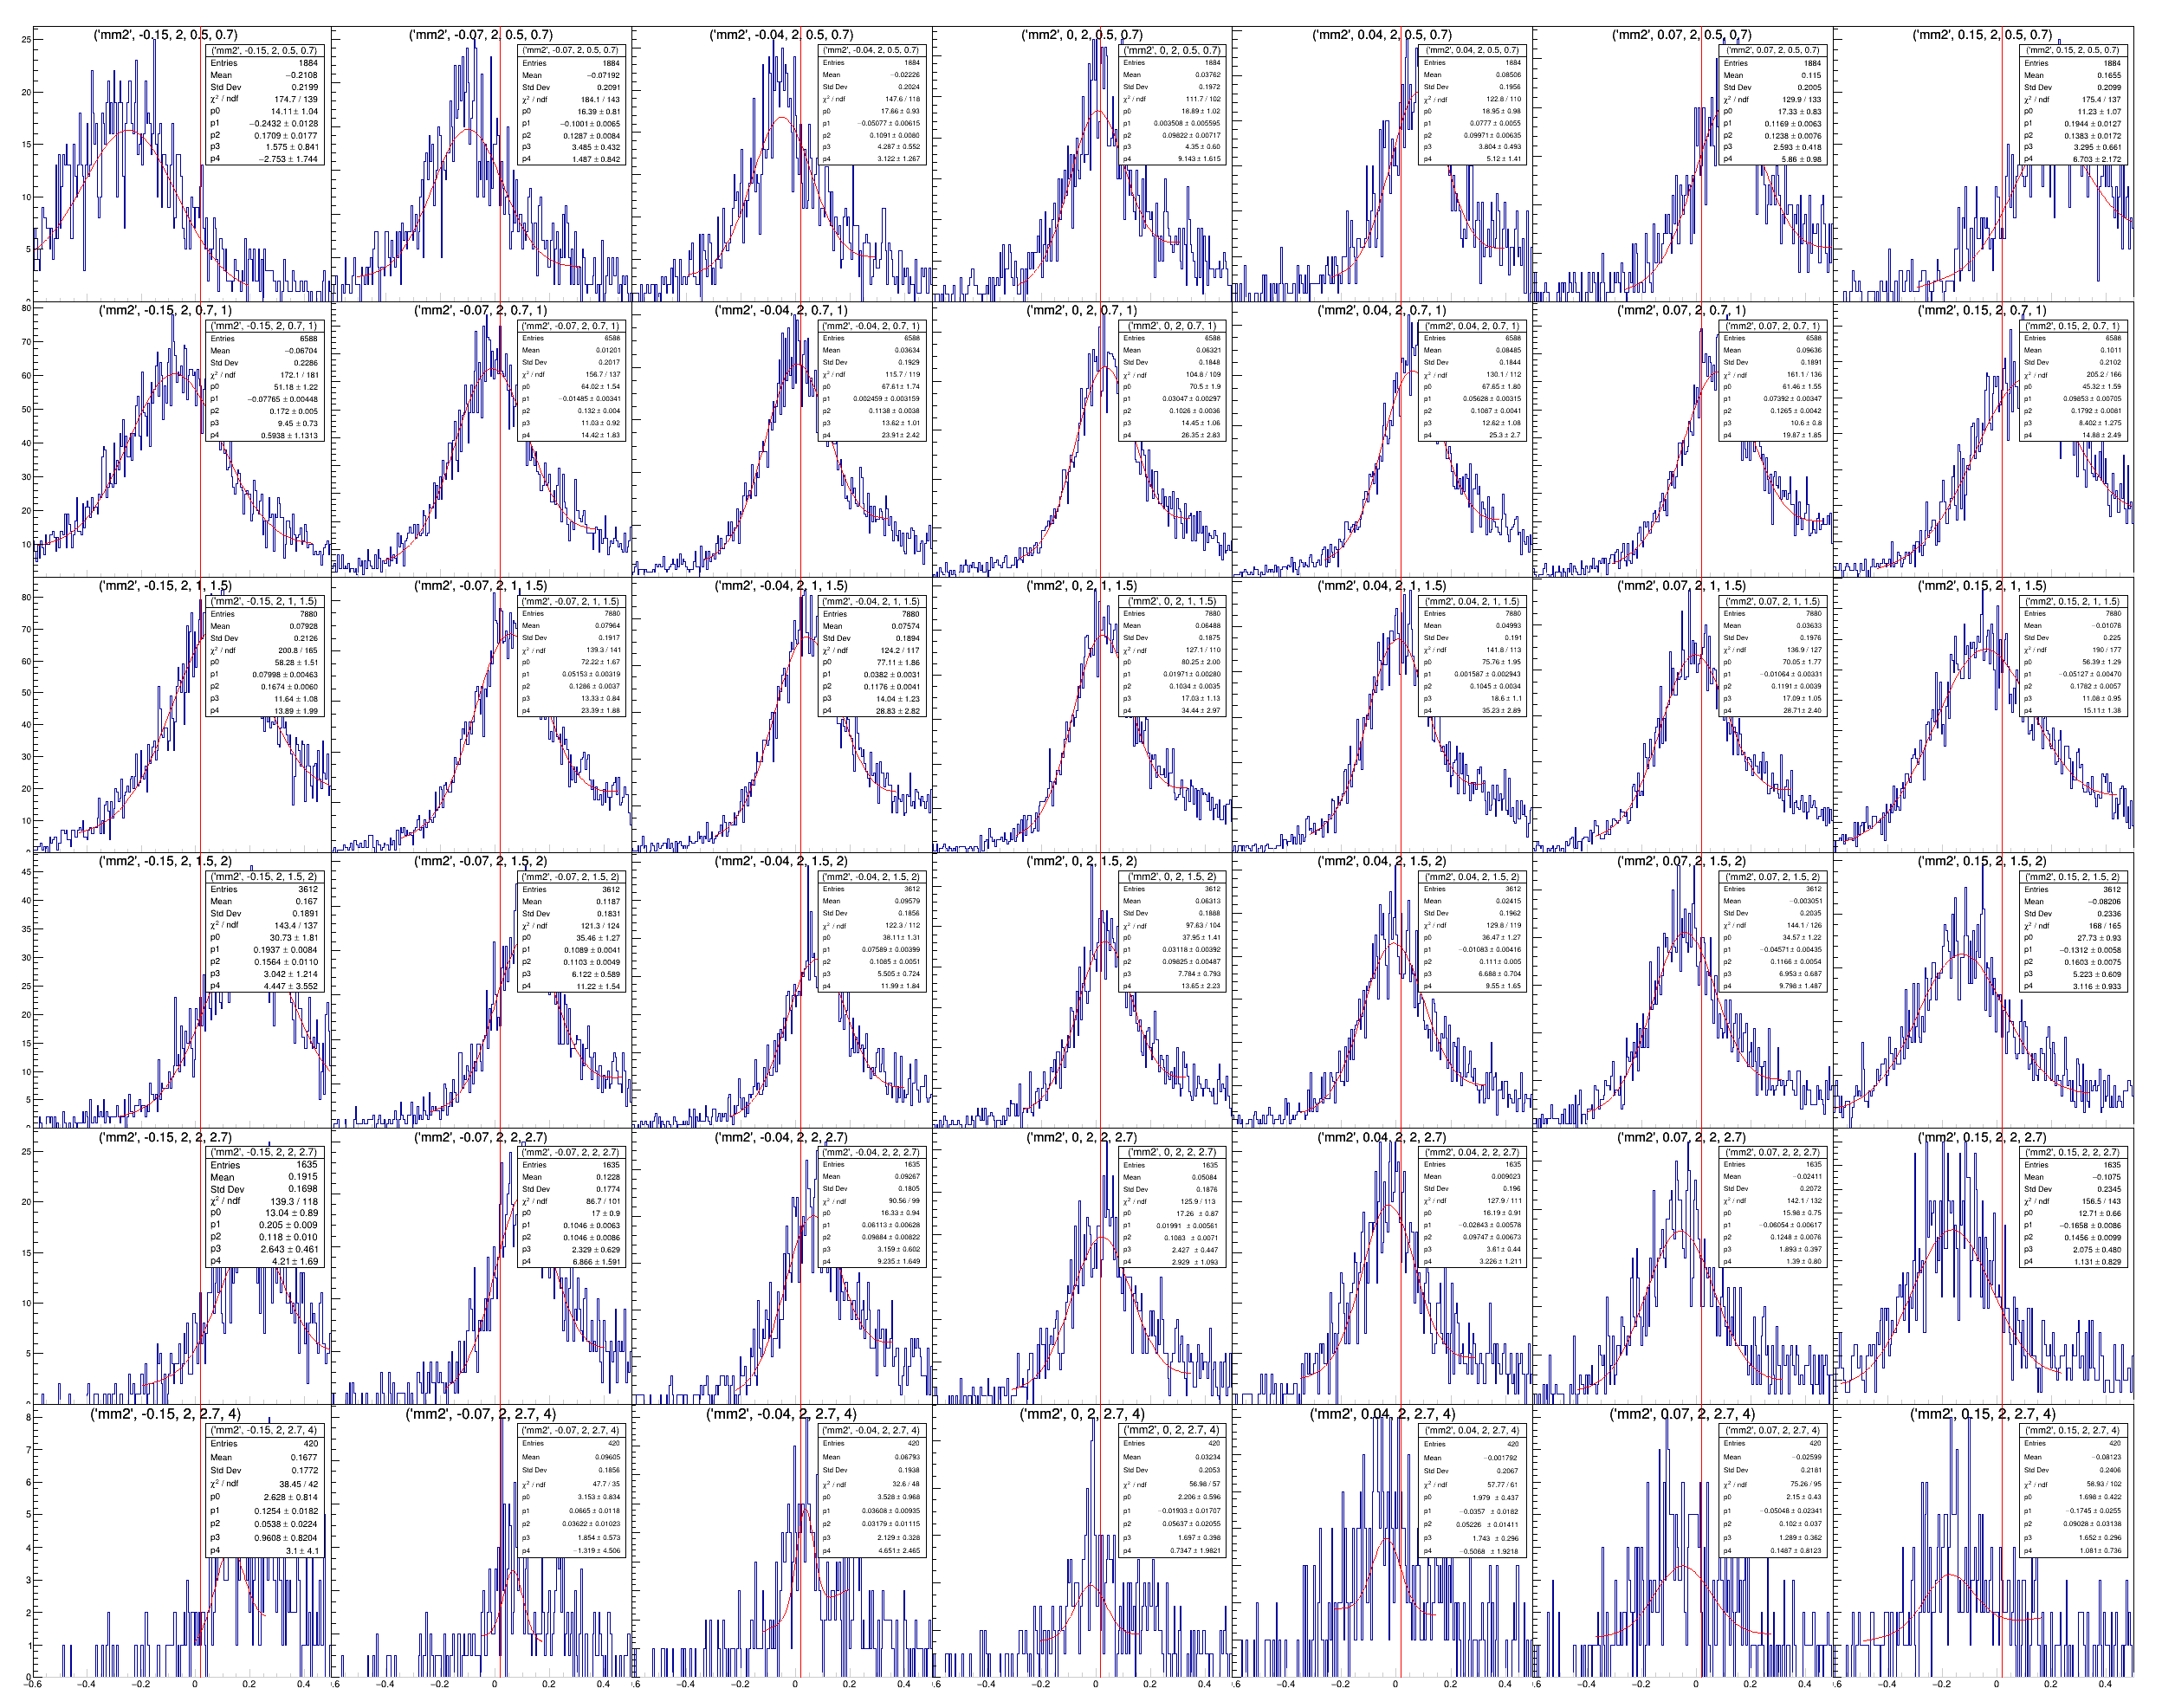

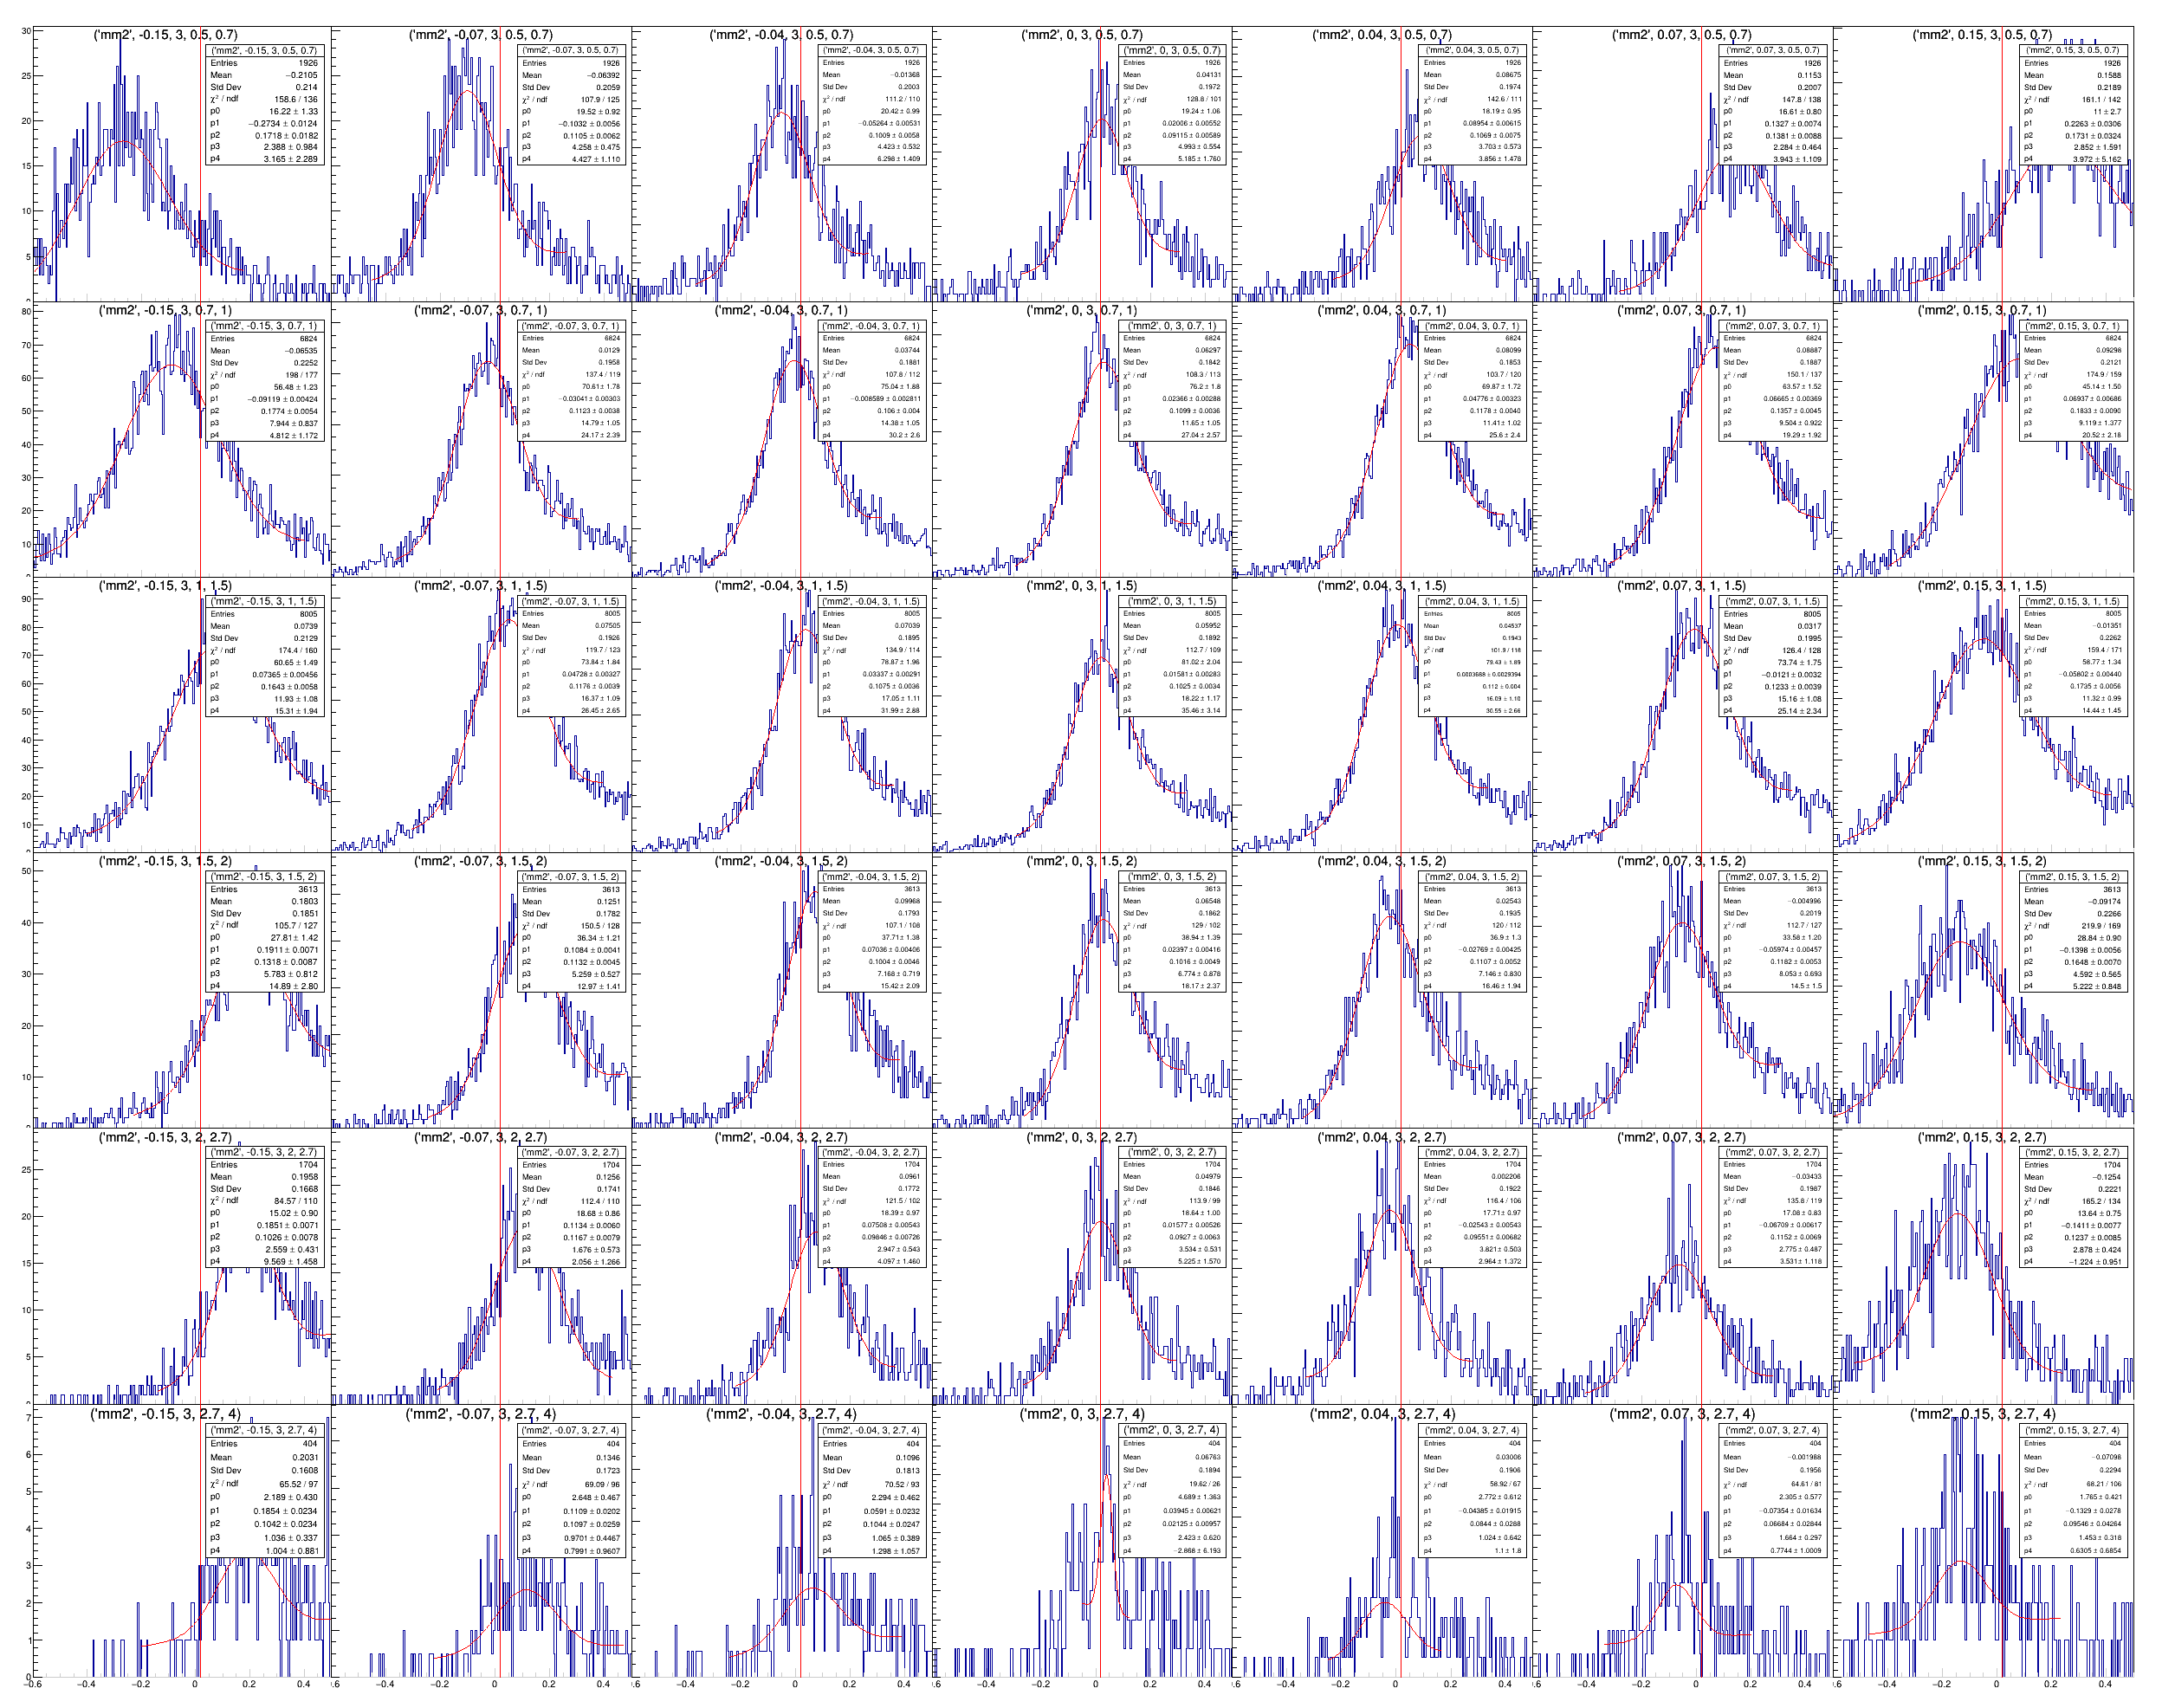

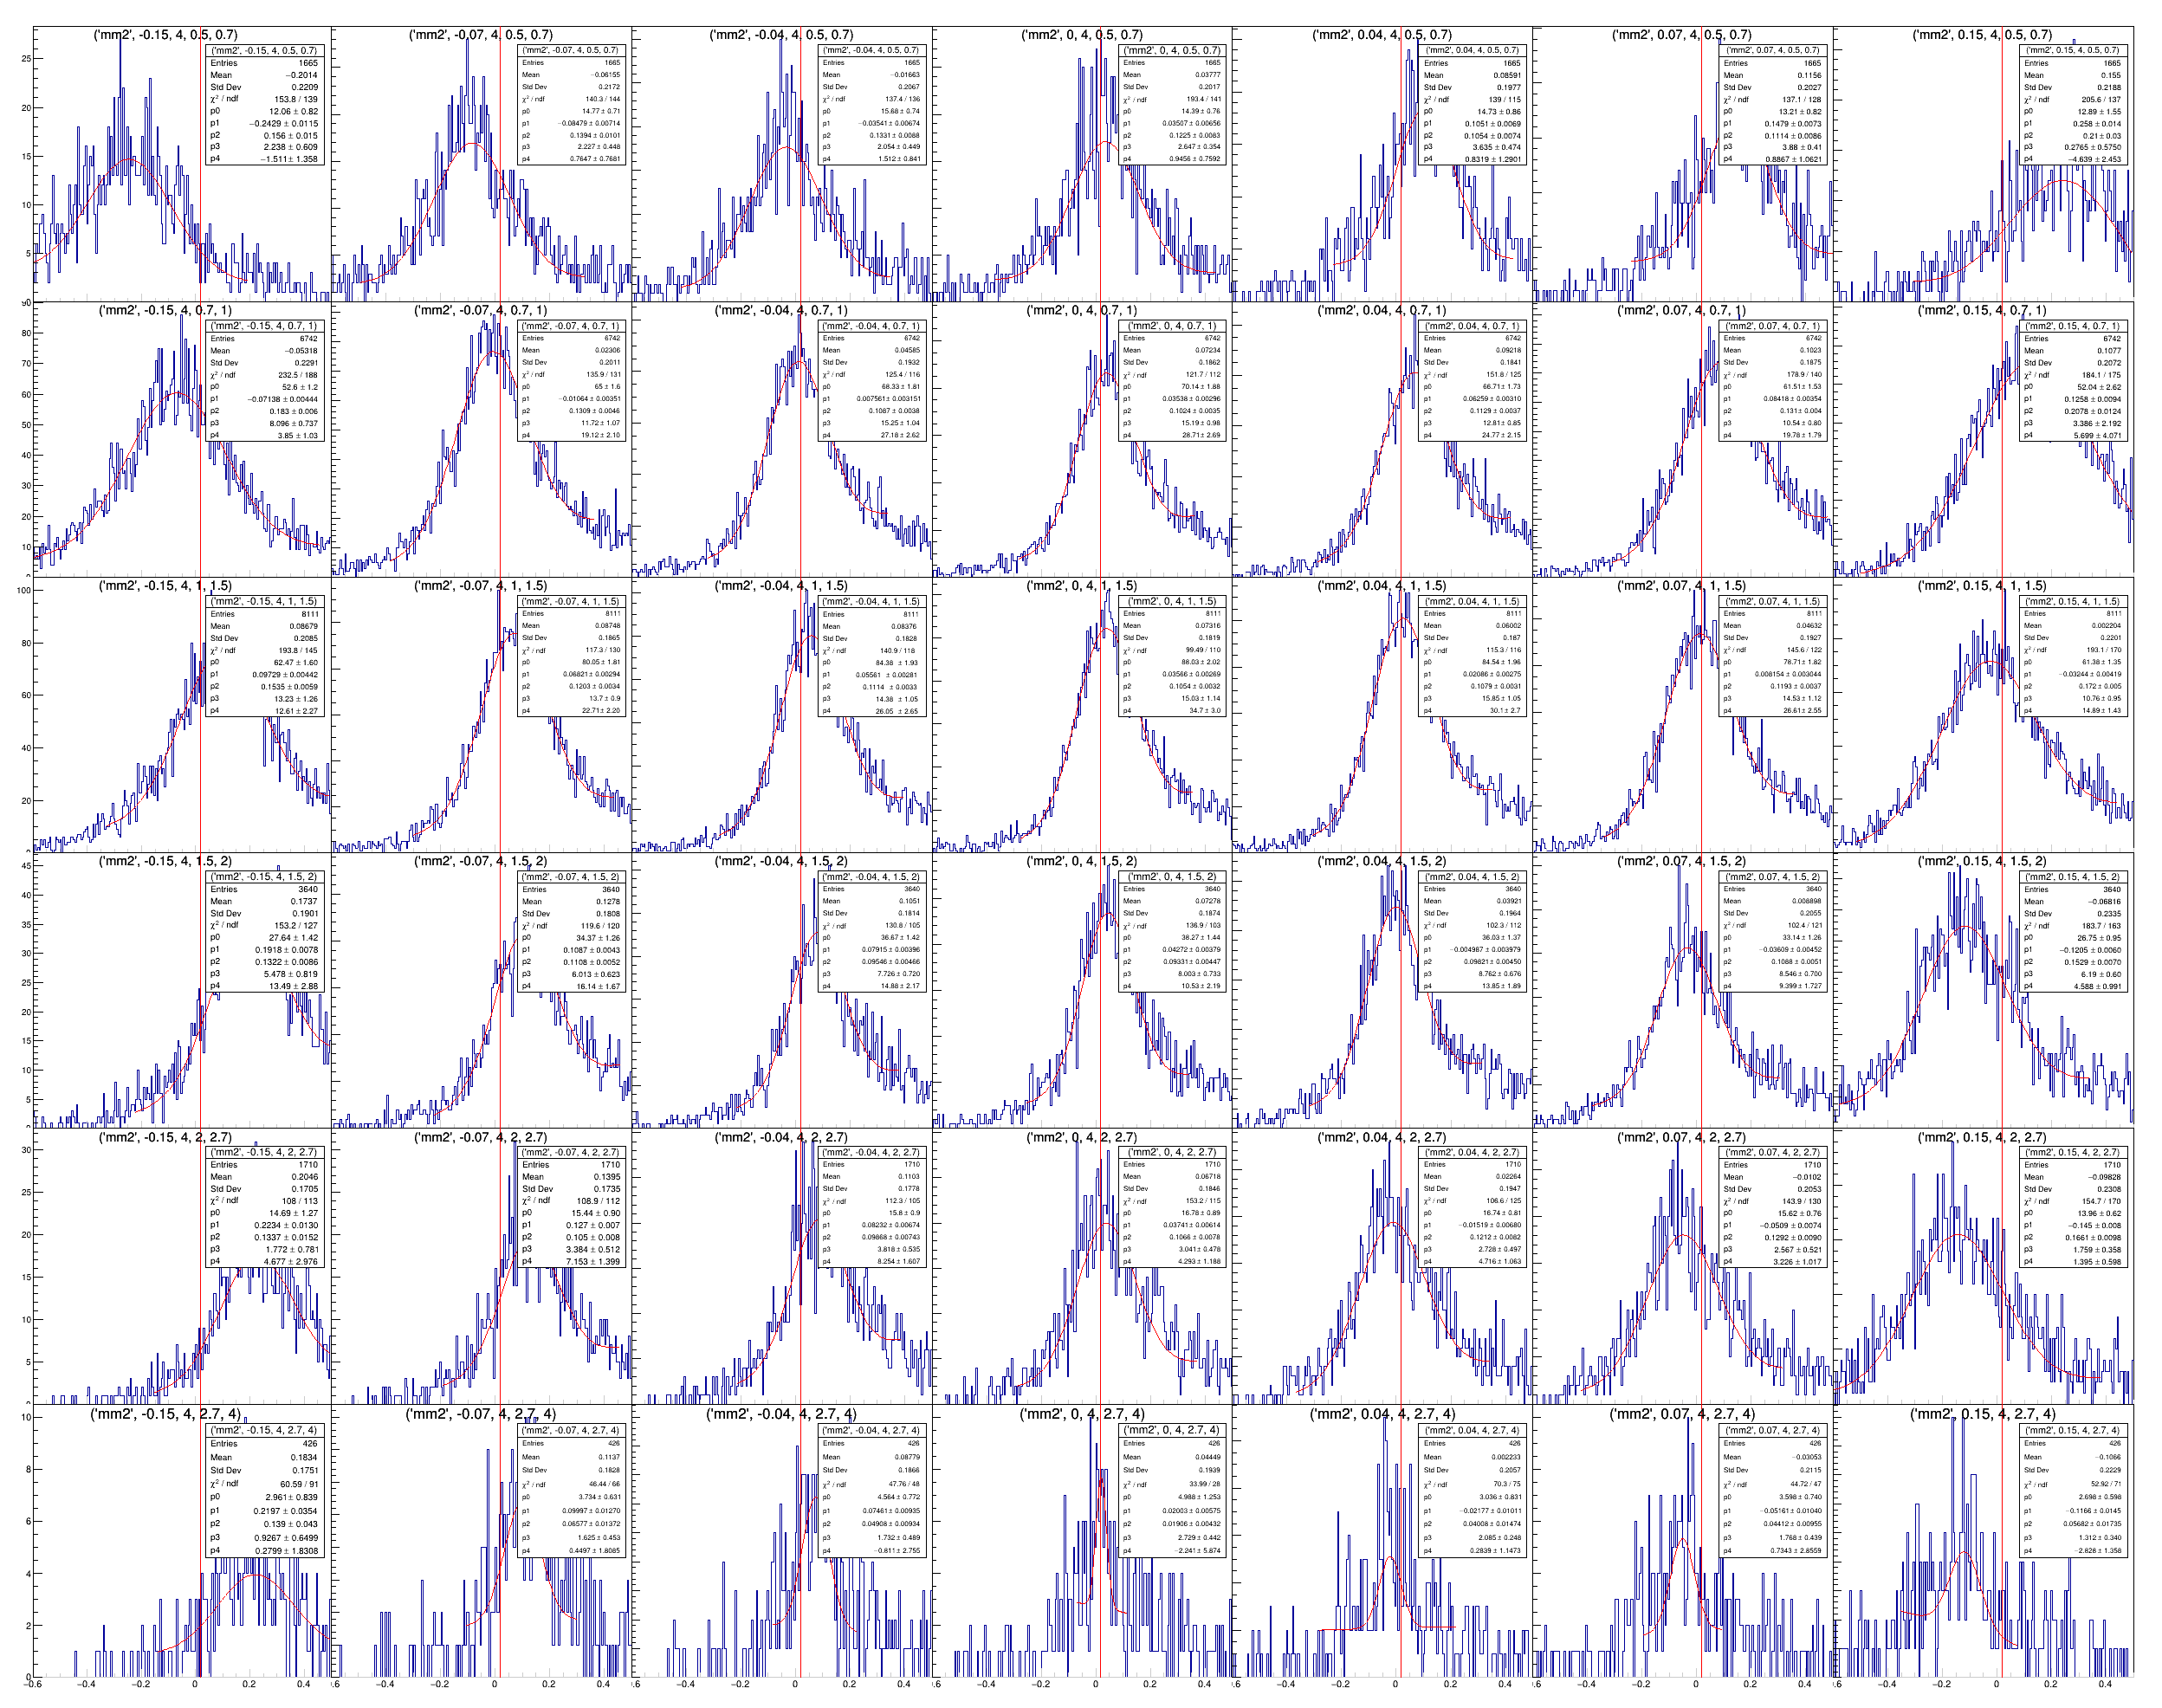

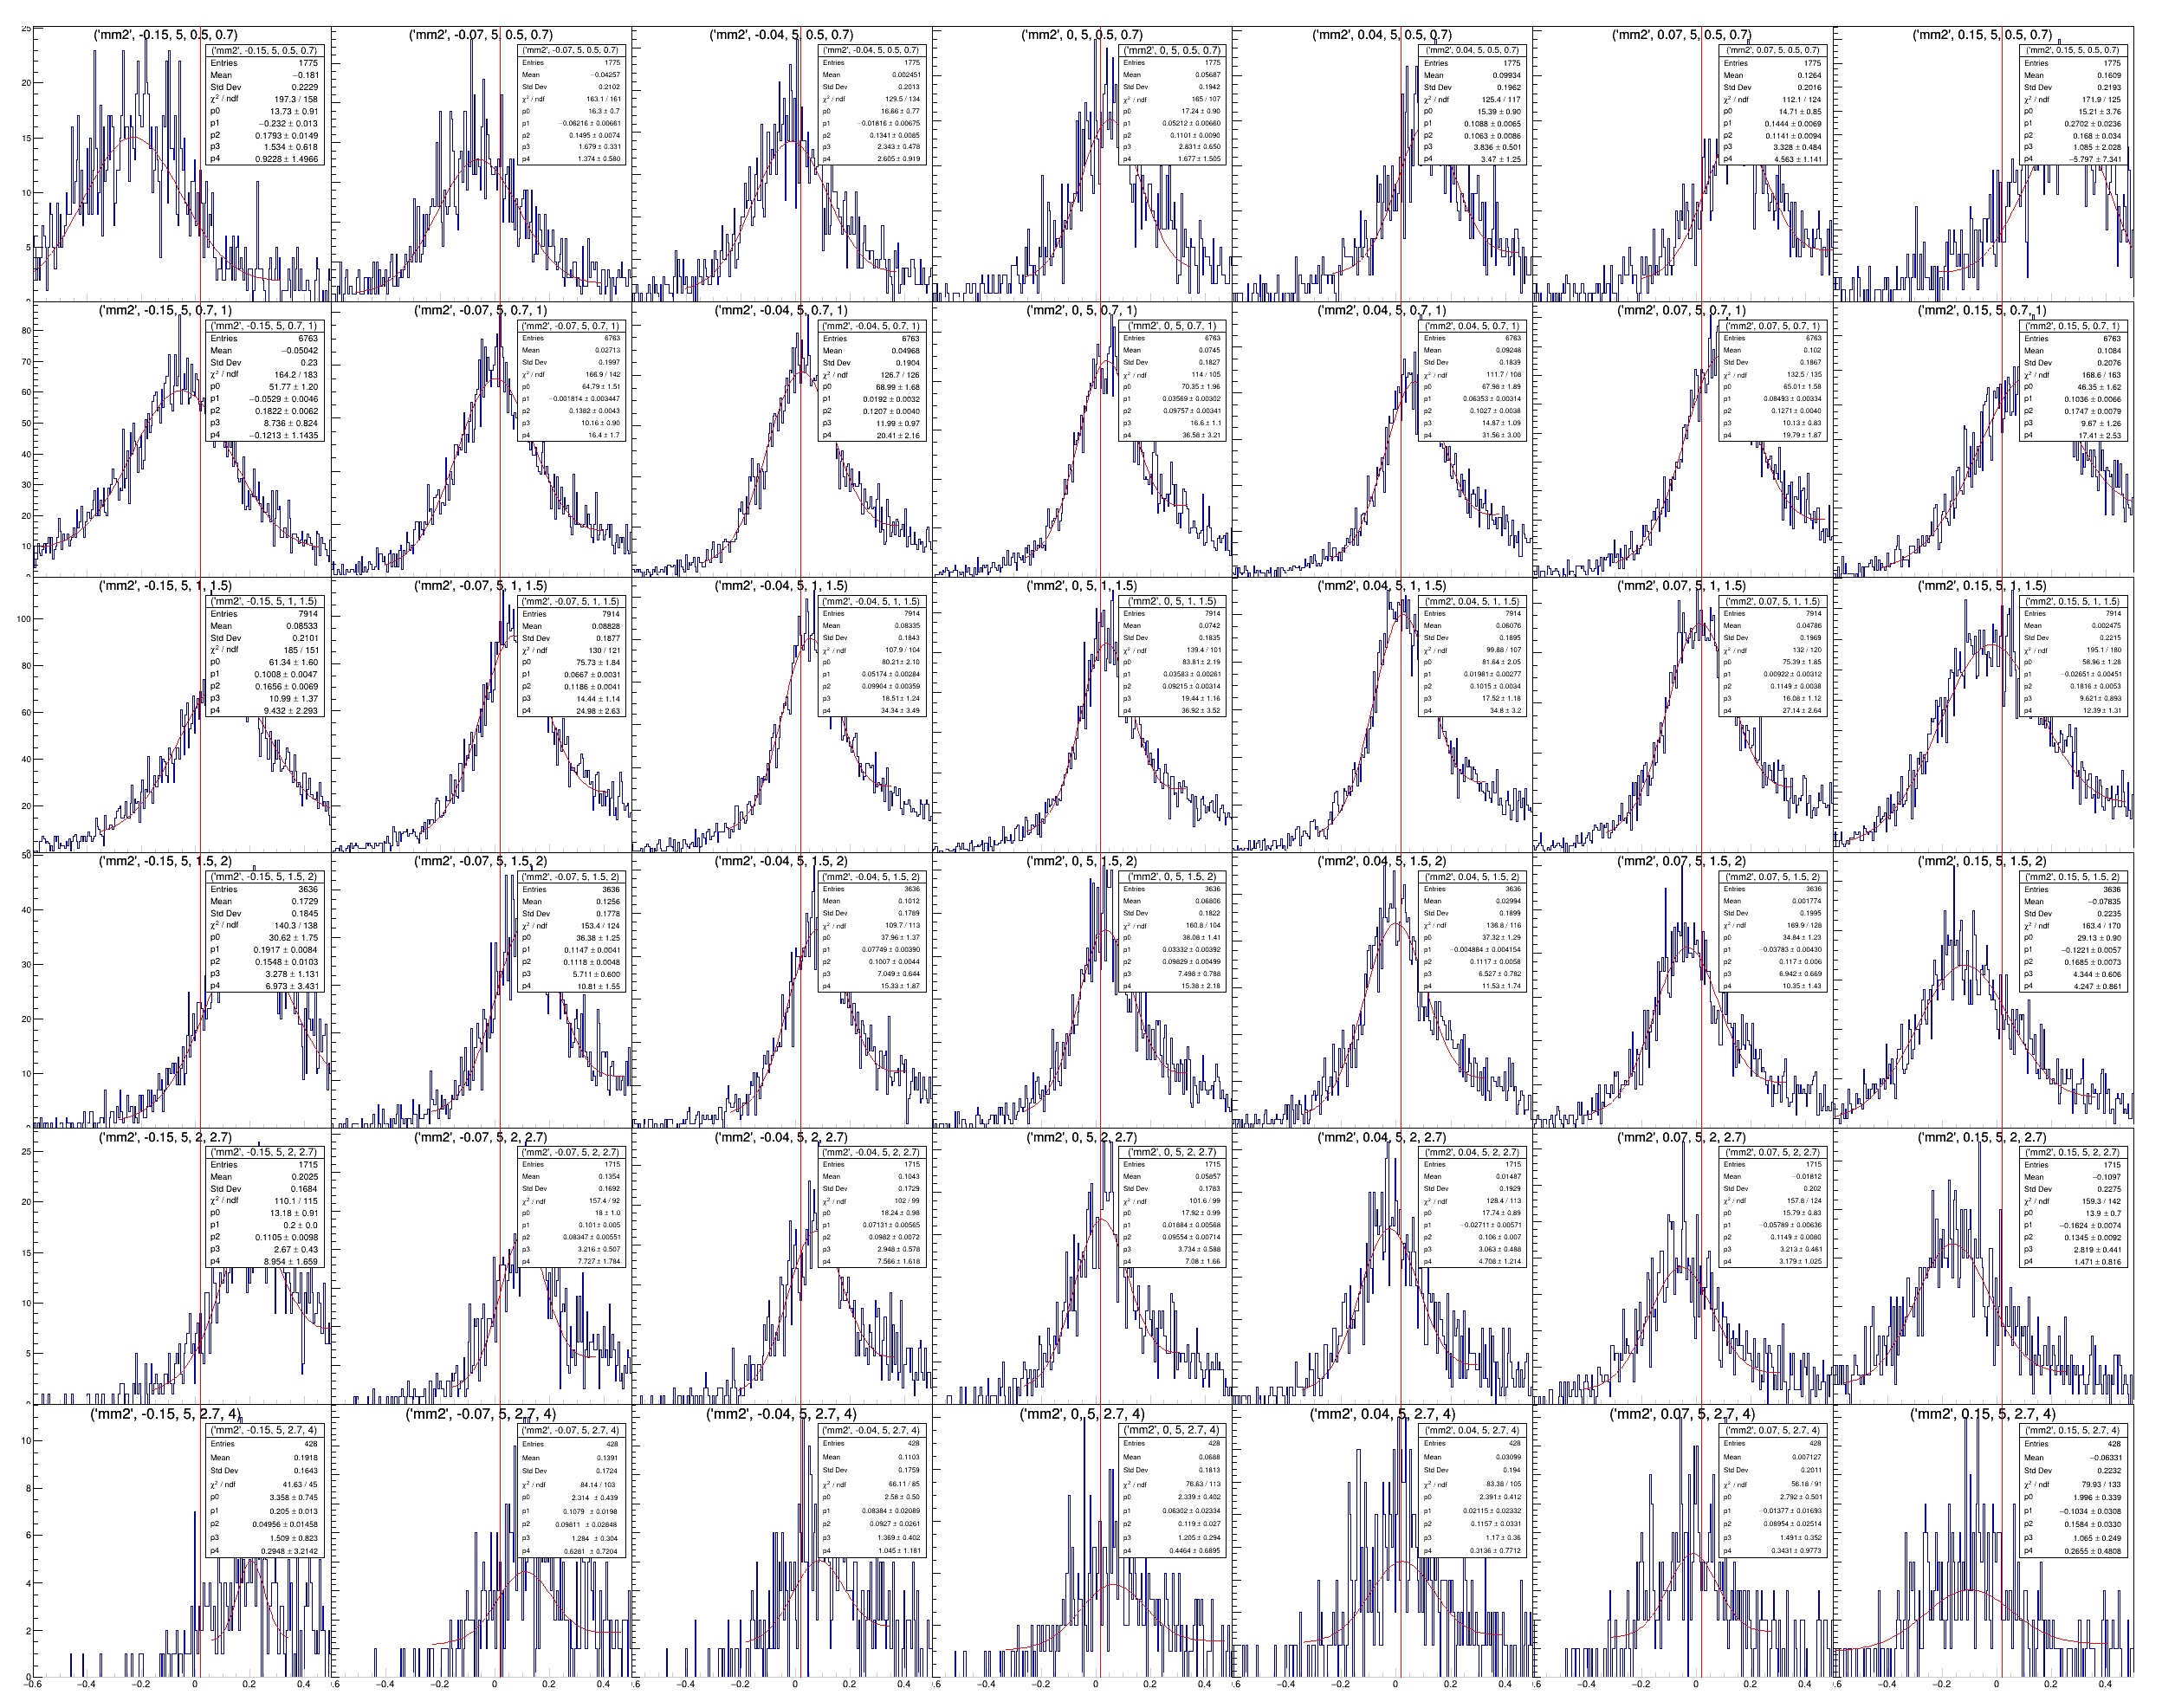

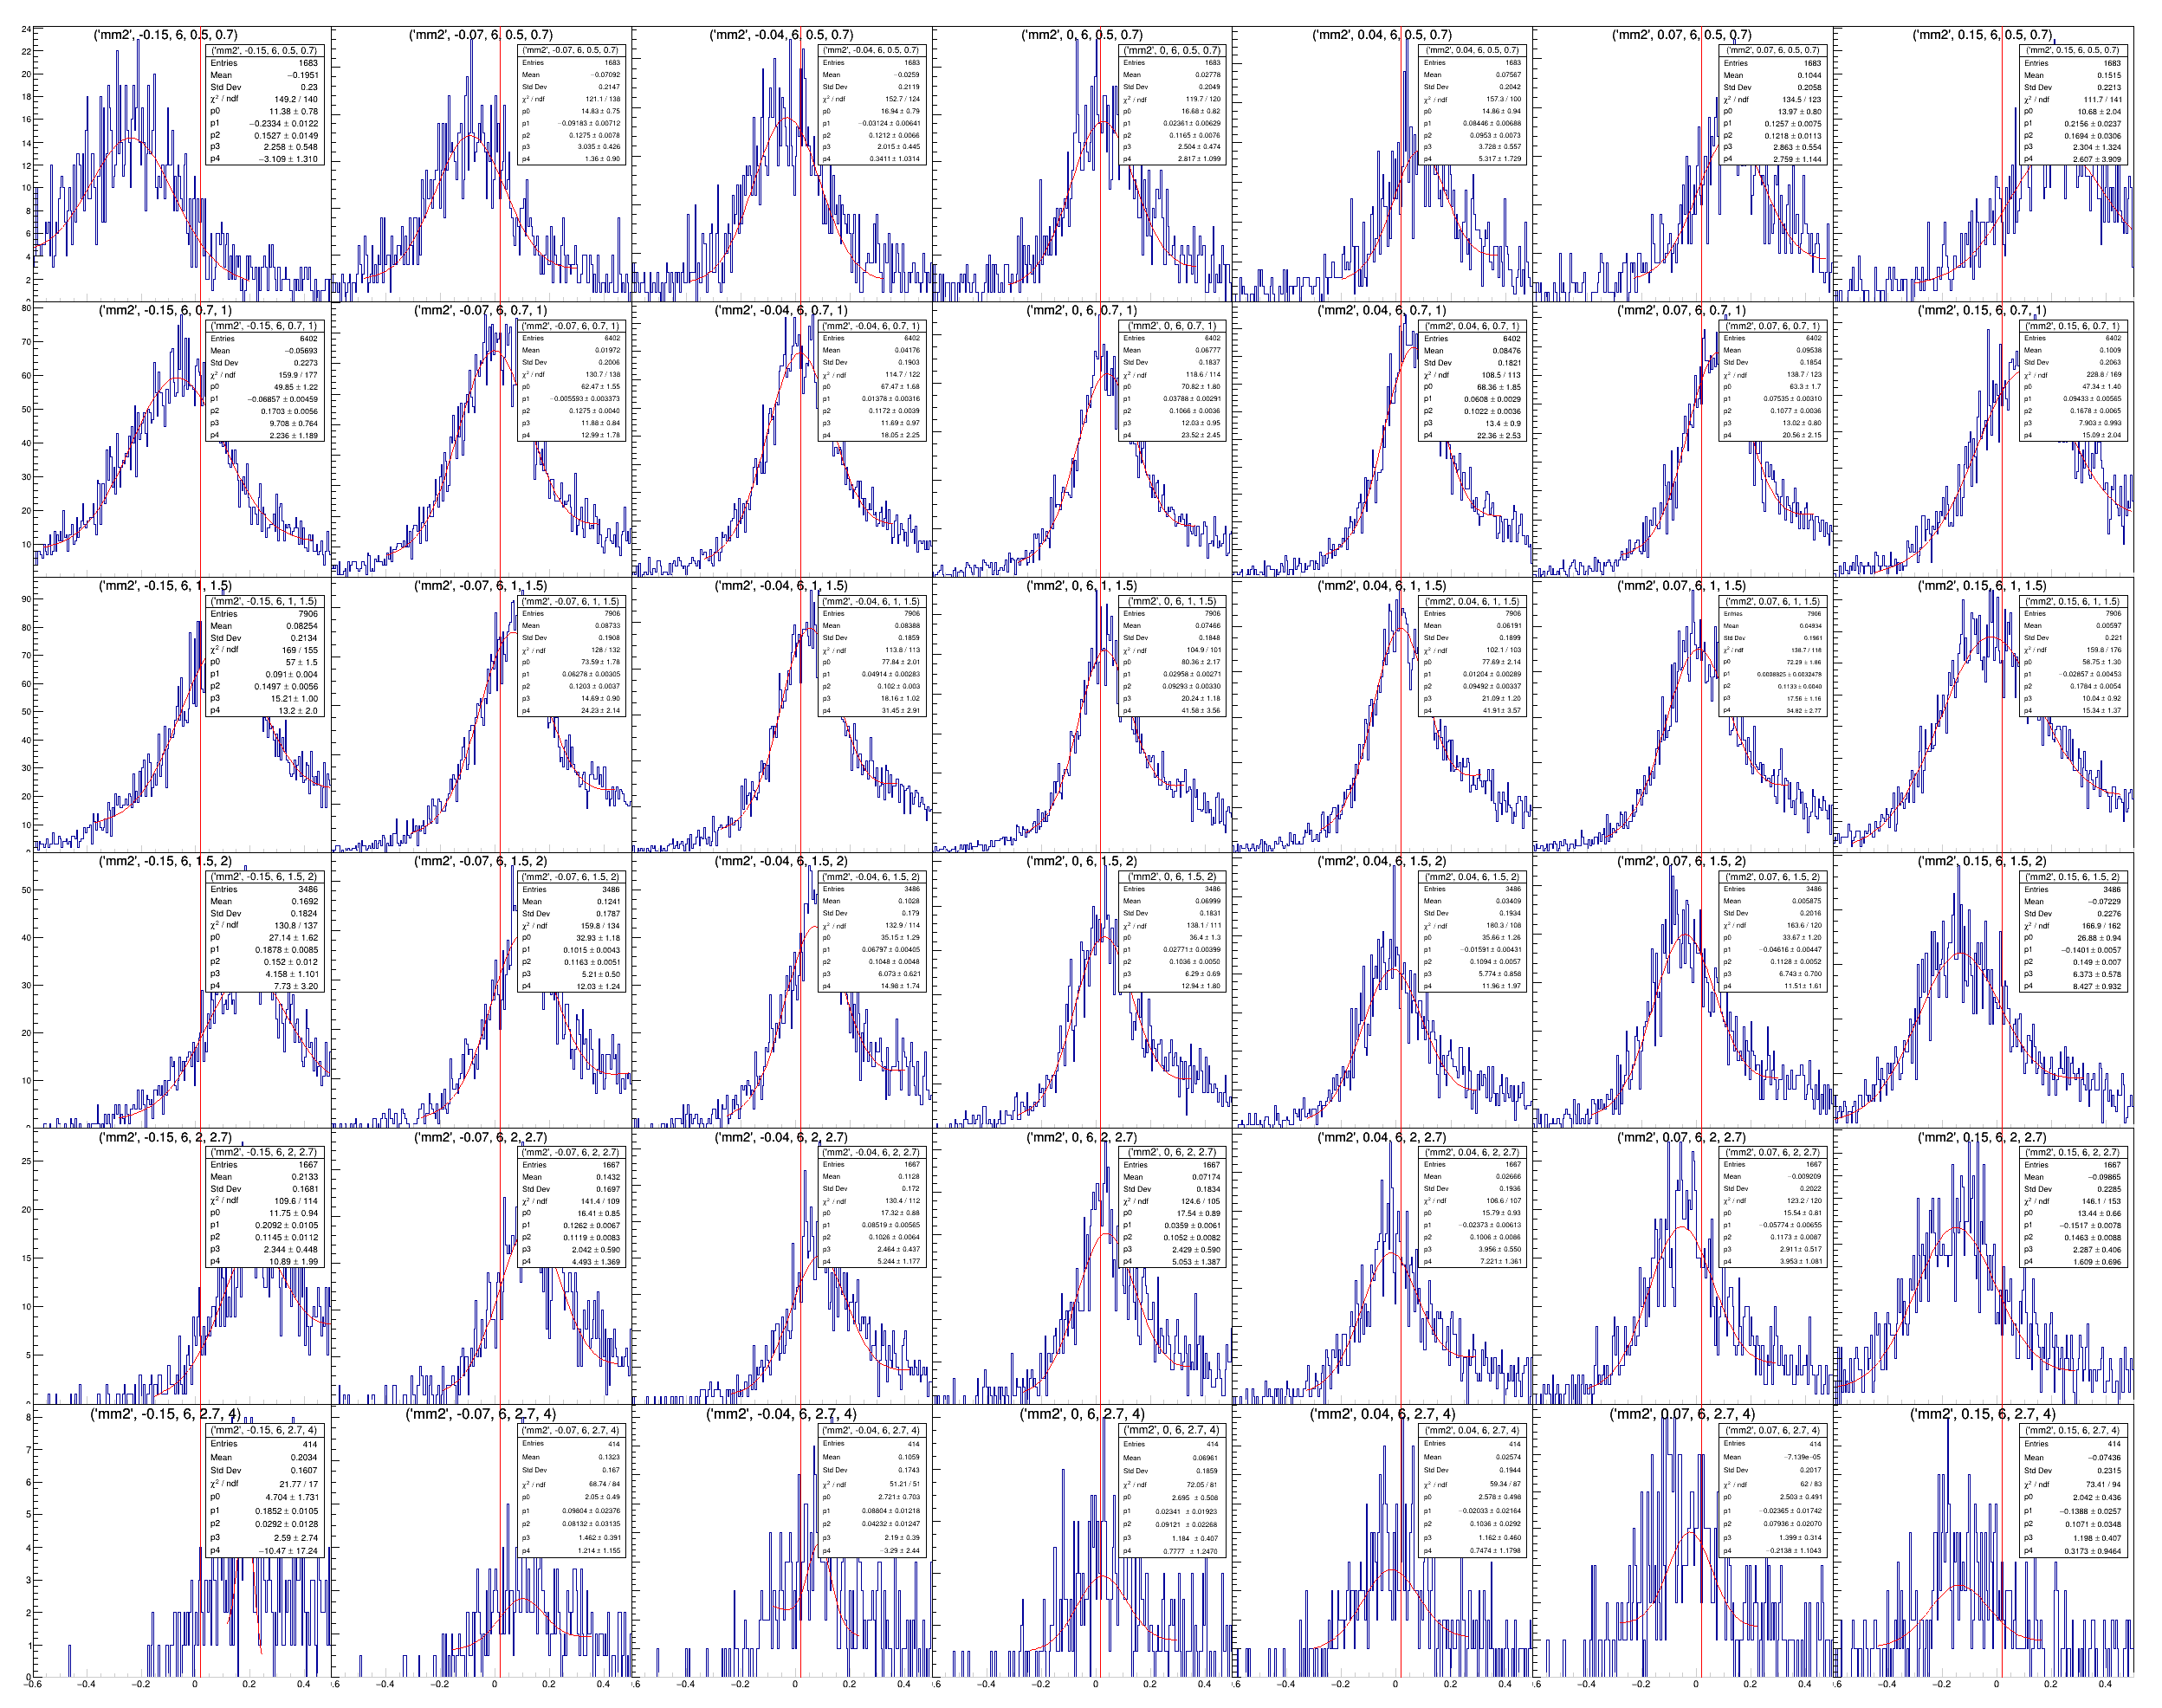

In [20]:
c1s=[]

ll = ROOT.TLine()
ll.SetLineColor(2)
for sec in range(1,7):
    c1 = ROOT.TCanvas(f"c{sec}", f"c{sec}", 2500,2000)
    c1s.append(c1)
    c1.Divide(len(dpps), len(pplims)-1,0,0)
    c1.Draw()
    
    ipad=0
    kks = [kk for kk in hss if len(kk)>2 and kk[0]==sec]
    for key in sorted(kks, key=lambda kk: (kk[2].GetValue(), kk[1])):
        ipad+=1
        c1.cd(ipad)
        
        h1 = hss[key]
        sec,dpp,ppm = key
        ppm = round(ppm.GetValue(),3)
        h1.Draw()
        ll.DrawLine(0.018225,0,0.018225,h1.GetMaximum()*1.1)
